In [1]:
import random
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from dataclasses import dataclass

In [104]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed);

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

Using device cuda


### Prepare the data

In [4]:
class ImpurityDataset(Dataset):
    
    def __init__(self, dataframe, fixed_features, labels, feature_scaler=None, label_scaler=None, device=None):
        assert len(labels) % 2 == 0
        
        self.fixed_features = fixed_features
        self.labels = labels
        self.n_samples = len(dataframe)
        
        self.output_length = len(labels)
        self.input_length = len(fixed_features)
        self.sequence_length = 1
        
        df_features = dataframe[fixed_features]
        df_labels = dataframe[labels]

        if feature_scaler is not None and label_scaler is not None:
            xs = feature_scaler.transform(df_features.values)
            ys = label_scaler.transform(df_labels.values)
        else:
            xs = df_features.values
            ys = df_labels.values

        feature_data = np.zeros((self.n_samples, self.sequence_length, self.input_length))
        label_data = np.zeros((self.n_samples, self.sequence_length, self.output_length))
        
        for i in range(self.n_samples):
            xi = xs[i]
            yi = ys[i]
            
            feature_data[i, :, :] = xi
            label_data[i, :, :] = yi

        self.feature_data = torch.tensor(feature_data, dtype=torch.float).to(device)
        self.label_data = torch.tensor(label_data, dtype=torch.float).to(device)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.feature_data[idx], self.label_data[idx]

In [5]:
def compute_scalers(dataframe, fixed_features, labels, test_size, random_state=None):
    train_df, _ = train_test_split(dataframe, test_size=test_size, random_state=random_state)
    df_features = train_df[fixed_features]
    df_labels = train_df[labels]
    
    feature_scaler = StandardScaler()
    feature_scaler.fit(df_features.values)
    
    label_scaler = StandardScaler()
    label_scaler.fit(df_labels.values)

    return feature_scaler, label_scaler      

In [6]:
file_path = '../../data/20230825_144318_10k_EVDoubExp-TExp-wmax5-sparse-hyb_with_perturbation.csv'

#fixed_features = ['beta', 'U', 'Eimp', 'E1', 'E2', 'E3', 'V1', 'V2', 'V3']

# original feature set
#fixed_features = ['beta', 'E1', 'E2', 'E3', 'V1', 'V2', 'V3']

fixed_features = ['beta', 'E1', 'E2', 'E3', 'V1', 'V2', 'V3', 'ReFso1', 'ImFso1', 'ReFso3', 'ImFso3', 'ReFso5', 'ImFso5', 'ReFso7', 'ImFso7', 'ReFso9', 'ImFso9', 'ReFso11', 'ImFso11', 'ReFso13', 'ImFso13', 'ReFso15', 'ImFso15', 'ReFso17', 'ImFso17', 'ReFso19', 'ImFso19', 'ReFso21', 'ImFso21', 'ReFso23', 'ImFso23', 'ReFso25', 'ImFso25', 'ReFso29', 'ImFso29', 'ReFso33', 'ImFso33', 'ReFso37', 'ImFso37', 'ReFso43', 'ImFso43', 'ReFso49', 'ImFso49', 'ReFso57', 'ImFso57', 'ReFso69', 'ImFso69', 'ReFso83', 'ImFso83', 'ReFso101', 'ImFso101', 'ReFso127', 'ImFso127', 'ReFso165', 'ImFso165', 'ReFso237', 'ImFso237', 'ReFso399', 'ImFso399', 'ReFso1207', 'ImFso1207']

labels = ['ReSf1', 'ImSf1', 'ReSf3', 'ImSf3', 'ReSf5', 'ImSf5', 'ReSf7', 'ImSf7', 'ReSf9', 'ImSf9', 'ReSf11', 'ImSf11', 'ReSf13', 'ImSf13', 'ReSf15', 'ImSf15', 'ReSf17', 'ImSf17', 'ReSf19', 'ImSf19', 'ReSf21', 'ImSf21', 'ReSf23', 'ImSf23', 'ReSf25', 'ImSf25', 'ReSf29', 'ImSf29', 'ReSf33', 'ImSf33', 'ReSf37', 'ImSf37', 'ReSf43', 'ImSf43', 'ReSf49', 'ImSf49', 'ReSf57', 'ImSf57', 'ReSf69', 'ImSf69', 'ReSf83', 'ImSf83', 'ReSf101', 'ImSf101', 'ReSf127', 'ImSf127', 'ReSf165', 'ImSf165', 'ReSf237', 'ImSf237', 'ReSf399', 'ImSf399', 'ReSf1207', 'ImSf1207']

df = pd.read_csv(file_path, skiprows=4) # we skip the first four lines, because they are just metadata
df = df[fixed_features + labels]

# remove one special row, looks very weird; ReSf1 = 2.377167465976437e-06
df = df[df['ReSf1'] >= 1e-05]

validation_size = 0.1 # 90% training, 10% for validation

use_scaling = True

if use_scaling:
    feature_scaler, label_scaler = compute_scalers(df, fixed_features, labels, validation_size, seed) # make sure we use the same seed, otherwise the two splits differ!
    dataset = ImpurityDataset(df, fixed_features, labels, feature_scaler, label_scaler, device=device)
else:
    dataset = ImpurityDataset(df, fixed_features, labels, device=device)

indices = list(range(len(dataset)))
train_indices, val_indices = train_test_split(indices, test_size=validation_size, random_state=seed)  # make sure we use the same seed, otherwise the two splits differ!

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0)

In [7]:
dataset.__getitem__(0);

In [8]:
sorted(df['ReSf1'].abs())[:10];

### Define the model

In [9]:
@dataclass
class ModelConfig:
    input_dim: int
    output_dim: int
    sequence_length: int
    
    d_model: int
    num_layers: int
    dim_feedforward: int
    
    dropout: float
    bias: bool

class CustomFeedForwardLayer(nn.Module):
    def __init__(self, d_model, dim_feedforward, dropout, bias):
        super(CustomFeedForwardLayer, self).__init__()

        self.value_projection = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model, bias=bias),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        self.feed_forward = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, dim_feedforward, bias=bias),
            nn.GELU(),
            nn.Linear(dim_feedforward, d_model, bias=bias),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        x = x + self.value_projection(x)
        x = x + self.feed_forward(x)
        return x

class CustomModel(nn.Module):
    
    def __init__(self, config, device):
        super(CustomModel, self).__init__()

        self.config = config
        self.input_projection = nn.Linear(config.input_dim, config.d_model)
        
        self.layers = nn.ModuleList([
                    CustomFeedForwardLayer(
                        d_model=config.d_model, 
                        dim_feedforward=config.dim_feedforward, 
                        dropout=config.dropout, 
                        bias=config.bias
                    )
                    for _ in range(config.num_layers)
                ])

        self.output_layer = nn.Linear(config.d_model, config.output_dim)
        
    def forward(self, x):        
        x = self.input_projection(x)
        
        for layer in self.layers:
            x = layer(x)
        
        x = self.output_layer(x)
        
        return x

### Initialize the model

In [105]:
config = ModelConfig(
    input_dim = len(fixed_features),
    output_dim = len(labels),
    sequence_length = 1,
    
    d_model = 128,
    num_layers = 4,
    dim_feedforward = 128 * 4,
    
    dropout = 0.2,
    bias = True
)

model = CustomModel(config, device).to(device)
print(sum(p.numel() for p in model.parameters())/1e3, 'k parameters')

criterion = nn.MSELoss().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, threshold=5e-6, min_lr=1e-5, factor=0.8)

609.846 k parameters


In [106]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    losses = []
    
    for inputs, targets in loader:
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        losses.append(loss.item())

    return np.average(losses)

In [107]:
def validate(model, loader, criterion, device):
    model.eval()
    losses = []
    
    with torch.no_grad():
        
        for inputs, targets in loader:
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            losses.append(loss.item())
            
    return np.average(losses)

In [108]:
def validate_mape(model, loader, device, use_scaling=use_scaling, epsilon=1e-8):
    model.eval()
    losses = []
    
    with torch.no_grad():
        
        for inputs, targets in loader:
            outputs = model(inputs)
            
            if use_scaling:
                outputs = torch.tensor(reverse_tranform_output(outputs, label_scaler))
                targets = torch.tensor(reverse_tranform_output(targets, label_scaler))
            
            ape = torch.abs((targets - outputs) / (targets + epsilon))
            mape = torch.mean(ape) * 100
            
            losses.append(mape.item())

    return np.average(losses)

In [109]:
def reverse_tranform_output(data, scaler):
    B, T, C = data.shape
    data = data.view(B, T*C)
    data = data.cpu().numpy()
    return scaler.inverse_transform(data)

In [110]:
validate_mape(model, val_loader, device, use_scaling=use_scaling)

107.67731237411499

### Train the model

In [111]:
num_epochs = 1000

# Initialize variables to store the lowest losses and corresponding epochs
lowest_train_loss = float('inf')
lowest_val_loss = float('inf')
train_losses = []
train_mapes = []
best_train_epoch = -1
best_val_epoch = -1

for epoch in range(num_epochs):
    train(model, train_loader, optimizer, criterion, device)
    
    train_loss = validate(model, train_loader, criterion, device)
    val_loss = validate(model, val_loader, criterion, device)

    scheduler.step(train_loss)
    
    train_mape = validate_mape(model, train_loader, device, use_scaling=use_scaling)
    val_mape = validate_mape(model, val_loader, device, use_scaling=use_scaling)

    train_losses.append(train_loss)
    train_mapes.append(train_mape)
    
    print(f"Epoch {(epoch+1):3d}: Train Loss: {train_loss:.6f}, Train MAPE: {train_mape:.3f}%, Val Loss: {val_loss:.6f}, Val MAPE: {val_mape:.3f}%, lr: {scheduler.get_last_lr()}")
    
    if train_mape < lowest_train_loss:
        lowest_train_loss = train_mape
        best_train_epoch = epoch + 1

    if val_mape < lowest_val_loss:
        lowest_val_loss = val_mape
        best_val_epoch = epoch + 1

print(f"\nLowest Train Loss: {lowest_train_loss:.6f} at Epoch {best_train_epoch}")
print(f"Lowest Val Loss: {lowest_val_loss:.6f} at Epoch {best_val_epoch}")


Epoch   1: Train Loss: 0.077209, Train MAPE: 20.211%, Val Loss: 0.078445, Val MAPE: 23.748%, lr: [0.0001]
Epoch   2: Train Loss: 0.038427, Train MAPE: 11.764%, Val Loss: 0.046348, Val MAPE: 15.113%, lr: [0.0001]
Epoch   3: Train Loss: 0.027650, Train MAPE: 10.499%, Val Loss: 0.038257, Val MAPE: 12.781%, lr: [0.0001]
Epoch   4: Train Loss: 0.027050, Train MAPE: 9.146%, Val Loss: 0.036087, Val MAPE: 11.076%, lr: [0.0001]
Epoch   5: Train Loss: 0.024165, Train MAPE: 8.412%, Val Loss: 0.052740, Val MAPE: 9.954%, lr: [0.0001]
Epoch   6: Train Loss: 0.020364, Train MAPE: 7.272%, Val Loss: 0.029324, Val MAPE: 8.696%, lr: [0.0001]
Epoch   7: Train Loss: 0.021486, Train MAPE: 7.315%, Val Loss: 0.029953, Val MAPE: 8.403%, lr: [0.0001]
Epoch   8: Train Loss: 0.020318, Train MAPE: 6.173%, Val Loss: 0.029695, Val MAPE: 7.917%, lr: [0.0001]
Epoch   9: Train Loss: 0.016134, Train MAPE: 6.401%, Val Loss: 0.024025, Val MAPE: 7.311%, lr: [0.0001]
Epoch  10: Train Loss: 0.017586, Train MAPE: 6.601%, Val 

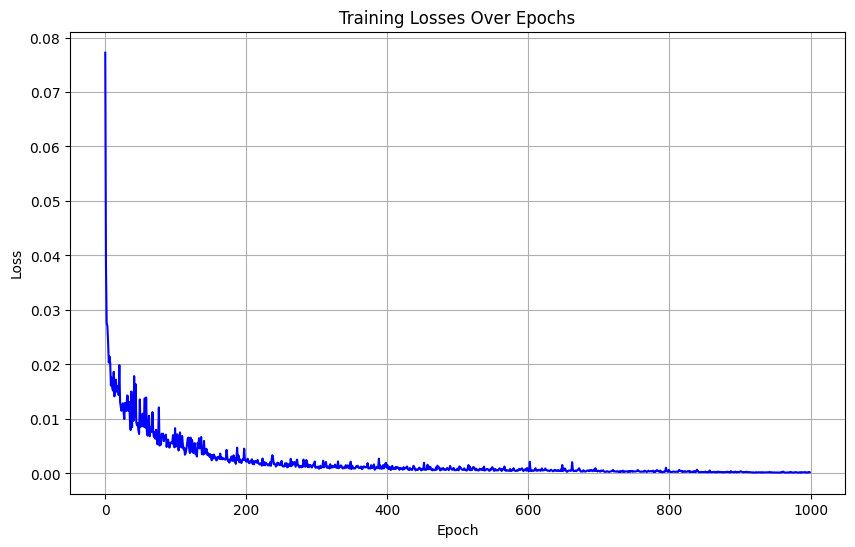

In [112]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 6))
plt.plot(train_losses, linestyle='-', color='b')
plt.title('Training Losses Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)